# Data analisys on Covid-19 

The basic idea here is following the trends of hospedalized cases, as they seems to be the more reliable data available today

In [273]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as pyplot
import glob
import numpy as np
from scipy import optimize
pd.set_option('mode.chained_assignment', None)

path = "COVID-19/dati-regioni"
all_files = glob.glob(path + "/*.csv")

datasets = []

for filename in all_files:
    data = pd.read_csv(filename)
    data['data'] = pd.to_datetime(data['data']).dt.normalize()
    valid_cases = data['totale_ospedalizzati'] + data['dimessi_guariti'] + data['deceduti']
    data['totali_accertati'] = valid_cases
    datasets.append(data)

df_italy =  pd.concat(datasets, axis=0, ignore_index=True)
df_italy = df_italy[['data','denominazione_regione', 'ricoverati_con_sintomi','terapia_intensiva','dimessi_guariti','deceduti','totali_accertati']]
df_italy = df_italy.sort_values(by=['data'])

display(df_italy.head())
%matplotlib inline

,data,denominazione_regione,ricoverati_con_sintomi,terapia_intensiva,dimessi_guariti,deceduti,totali_accertati
209,2020-02-24,Veneto,12,4,0,1,17
191,2020-02-24,P.A. Bolzano,0,0,0,0,0
192,2020-02-24,Calabria,0,0,0,0,0
193,2020-02-24,Campania,0,0,0,0,0
194,2020-02-24,Emilia Romagna,10,2,0,0,12


we need some functions for the logistic regression, that we want to apply to data per region

In [330]:
def sigmoid(p,x):
    x0,y0,c,k=p
    y = c / (1 + np.exp(-k*(x-x0))) + y0
    return y
 
def residuals(p,x,y):
    return y - sigmoid(p,x)

def vertline(x, max):
    """Draws a vertical line at x."""
    pyplot.plot([x, x], [0, max], '--' ,linewidth=2, color='0.8')
 

The idea behind this is to rely only on **valid** data, avoid the _POSITIVE_ definition that is misleading right now. The real definitio of _POSITIVE_ today is just the number of discovered cases in the day.

In [352]:

def plot_region(region_name):
    final = df_italy.copy()
    region = final[final['denominazione_regione']==region_name]
    region.drop_duplicates(subset='data',inplace=True)
    region['day'] = range(1,len(region)+1)
    x = region['day'].tolist()
    y = region['totali_accertati'].tolist() #.diff() in order to have deltas
    max = region['totali_accertati'].max()
    y[0] = 0.0
    pyplot.figure(figsize=[13.0,8.0])
    pyplot.title('Number of cases that require hospitalization')
    pyplot.xlabel('days from the beginning')
    pyplot.ylabel('number of cases')
    vertline(x[-1], max*1.5)  #today
    #pyplot.plot([x[-1], x[-1]], [0, 300], linewidth=3, color='0.8')
    pyplot.grid(b=True, color='g')
    pyplot.plot(x,y,'k-', alpha=0.5, label='real data')
    #z = np.polyfit(x, y, 3)
    #y1 = np.polyval(np.poly1d(z),x);
    #pyplot.plot(x,y1, alpha=0.3, label='polynomial regression')
    style = [('-.',0.3)]*len(x)
    style[len(x)-1] = ('*-.',0.9)
    for n in range(len(x)-5,len(x)):
        x0 = x[0:n]
        y0 = y[0:n]
        x_f = x0.copy()
        x_f.extend(range(len(x),len(x)+20))
        p, cov, infodict, mesg, ier = optimize.leastsq(residuals,[0,0,0,0],args=(x0,np.array(y0)),full_output=1)
        x1,y1,c,k=p
        pyplot.plot(x_f, c / (1 + np.exp(-k*((x_f)-x1))) + y1,style[n][0], alpha=style[n][1], label='logistic regression (day=%d)'%(n+1))
    pyplot.legend(loc='upper left')

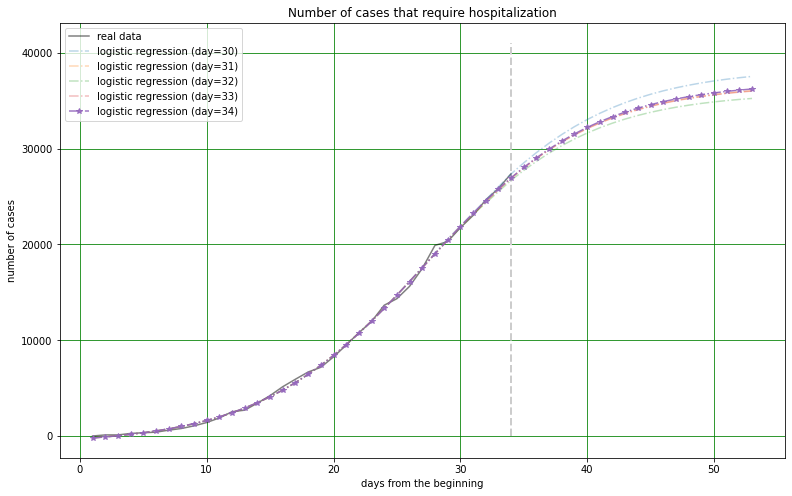

In [353]:
plot_region('Lombardia')

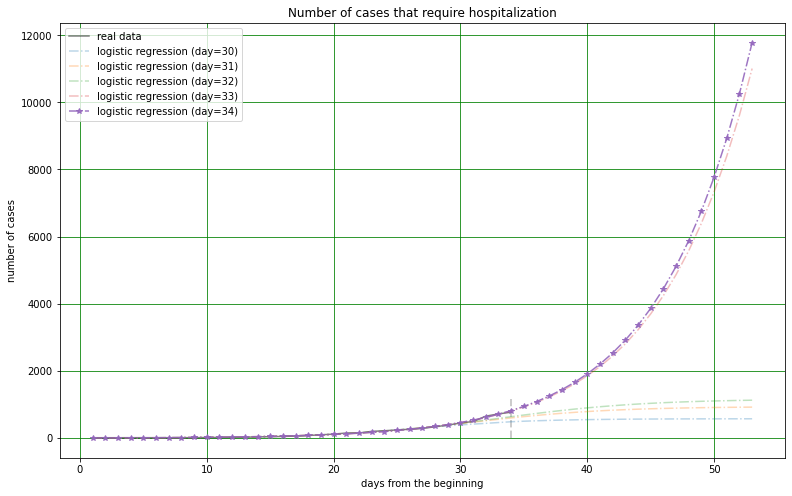

In [354]:
plot_region("Puglia")

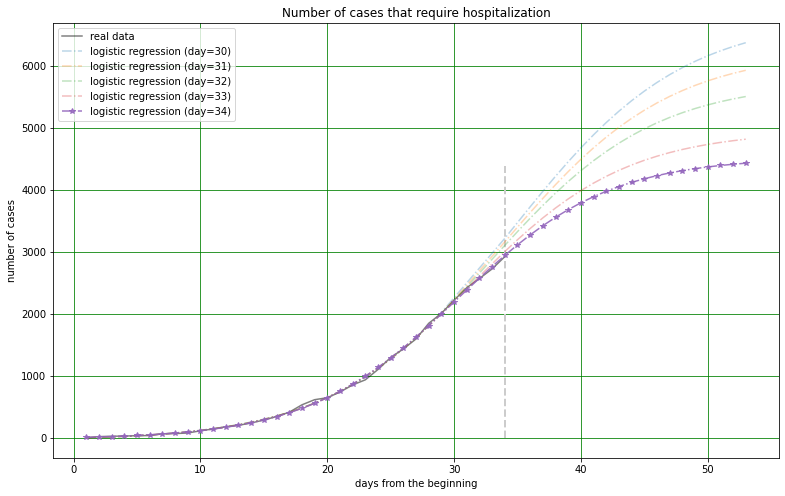

In [355]:
plot_region("Veneto")

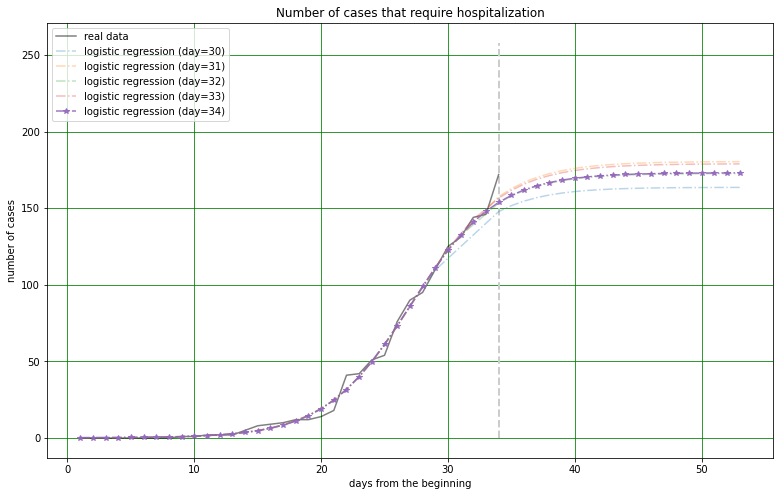

In [356]:
plot_region("Sardegna")